In [1]:
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import random
import itertools
import math
import shapefile
import seaborn as sns

from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import matplotlib as plt
import matplotlib.mlab
import matplotlib.pyplot

import geopandas as gpd
from dask.distributed import Client
from shapely.geometry import Point

from bokeh.io import output_notebook
from bokeh.models import GeoJSONDataSource, HoverTool, CategoricalColorMapper, LinearColorMapper, ContinuousColorMapper
from bokeh.plotting import figure, show
from bokeh.palettes import Category10, viridis, plasma, RdBu
from bokeh.models import ColorBar, LogColorMapper, ColumnDataSource, Grid, LinearAxis, Patches, Plot, BasicTicker, FixedTicker
from collections import OrderedDict

import dask.dataframe as dd
import dask

plt.pyplot.style.use('ggplot')
%matplotlib inline

In [2]:
# There are 0s in trip_distance tab, which means trip_distance is smaller than 0.01 miles
# Such short distance trip may not reflect godness of service, hence we remove them 
# Besides, we add columns of pickup and dropoff time
def preprocess(file_list):
    df_list = []
    for file in file_list:
        df = pd.read_csv(file)
        df = df[df["trip_distance"] != 0]
        try:
            df['pickup_hour'] = [x[11:13] for x in df['lpep_pickup_datetime']]
            df['dropoff_hour'] = [x[11:13] for x in df['lpep_dropoff_datetime']]
        except KeyError:
            df['pickup_hour'] = [x[11:13] for x in df['tpep_pickup_datetime']]
            df['dropoff_hour'] = [x[11:13] for x in df['tpep_dropoff_datetime']]
        df_list.append(df)
    return df_list

In [3]:
# Doing feature engineering, calculating trip time via pickup and dropoff time difference
def add_trip_time(df):
    df_drop = pd.to_datetime(df["tpep_dropoff_datetime"])
    df_pick = pd.to_datetime(df["tpep_pickup_datetime"])
    diff = (df_drop - df_pick) / pd.Timedelta(minutes=1)
    
    df["trip_time"] = diff
    return df

## Pre-processing

In [4]:
# Choose datasets of green and yellow taxis from March to June in 2020
file_list_green = []
file_list_yellow = []
for month in range(1, 7):
    file = "dataset/green_tripdata_2020-{0:0=2d}.csv".format(month)
    file_list_green.append(file)

for month in range(1, 7):
    file = "dataset/yellow_tripdata_2020-{0:0=2d}.csv".format(month)
    file_list_yellow.append(file)

In [5]:
# df_list_green = preprocess(file_list_green)
df_list_yellow = preprocess(file_list_yellow)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
# df_green = pd.concat(df_list_green)
df_yellow = pd.concat(df_list_yellow)

# df_green_raw = df_green
df_yellow_raw = df_yellow

In [7]:
df = df_yellow

In [8]:
# df.dropna(subset=['payment_type'], inplace=True)
# df.dropna(subset=['passenger_count'], inplace=True)
df.dropna(inplace=True)

In [9]:
df = add_trip_time(df)

In [10]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,trip_time
count,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07,1.637728e+07
mean,1.666986e+00,1.494643e+00,2.849516e+00,1.040372e+00,1.644151e+02,1.619960e+02,1.270471e+00,1.227023e+01,1.105674e+00,4.950610e-01,2.174037e+00,3.067520e-01,2.980931e-01,1.818281e+01,2.301521e+00,1.564850e+01
std,4.712916e-01,1.138632e+00,7.207970e+00,5.478612e-01,6.577402e+01,7.008397e+01,4.733770e-01,1.662069e+02,1.250945e+00,6.419800e-02,2.647417e+00,1.645832e+00,3.332779e-02,1.664021e+02,6.985719e-01,1.455320e+02
min,1.000000e+00,0.000000e+00,-2.218000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.259000e+03,-2.700000e+01,-5.000000e-01,-4.932200e+02,-4.000000e+01,-3.000000e-01,-1.260300e+03,-2.500000e+00,-5.312312e+05
25%,1.000000e+00,1.000000e+00,9.900000e-01,1.000000e+00,1.250000e+02,1.120000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.116000e+01,2.500000e+00,6.350000e+00
50%,2.000000e+00,1.000000e+00,1.610000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.416000e+01,2.500000e+00,1.040000e+01
75%,2.000000e+00,2.000000e+00,2.920000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.350000e+01,2.500000e+00,5.000000e-01,2.860000e+00,0.000000e+00,3.000000e-01,1.956000e+01,2.500000e+00,1.665000e+01
max,2.000000e+00,9.000000e+00,2.254399e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,6.711001e+05,1.130100e+02,3.951000e+01,1.100000e+03,9.255000e+02,3.000000e-01,6.711032e+05,2.750000e+00,8.525117e+03


In [11]:
df['trip_distance'].quantile(0.99)

18.89

In [12]:
df['trip_time'].quantile(0.99)

52.53333333333333

In [13]:
df['fare_amount'].quantile(0.99)

52.0

In [14]:
df['total_amount'].quantile(0.99)

73.7

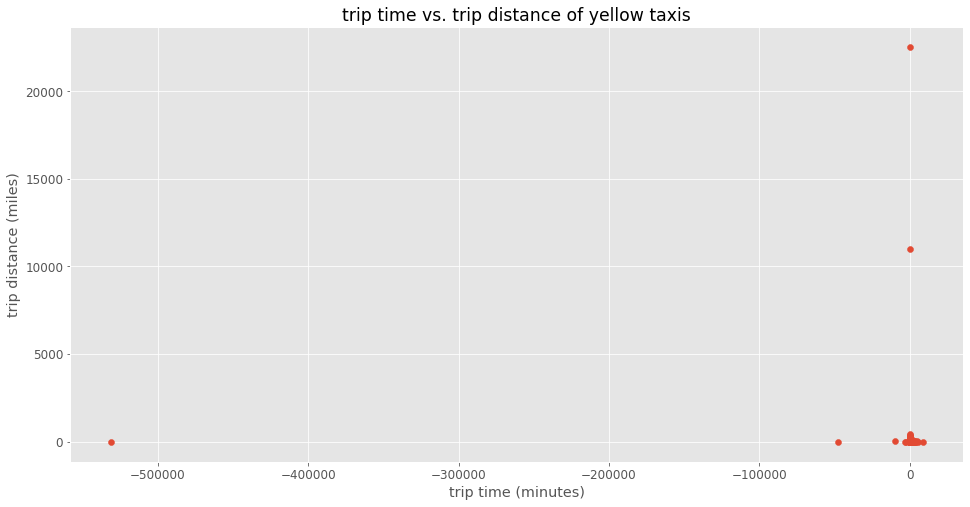

In [15]:
matplotlib.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df.trip_time, df.trip_distance)
plt.pyplot.title("trip time vs. trip distance of yellow taxis")
plt.pyplot.xlabel('trip time (minutes)')
plt.pyplot.ylabel('trip distance (miles)')
plt.pyplot.show()

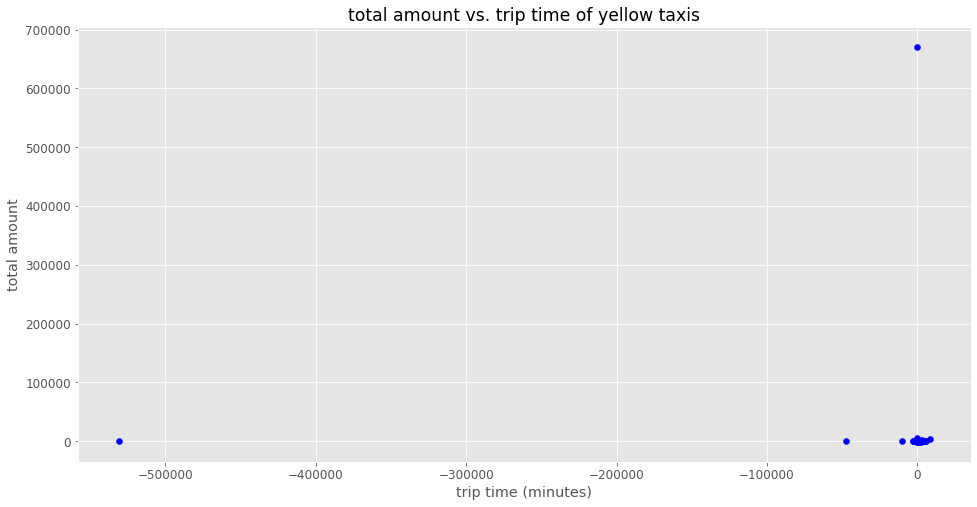

In [16]:
matplotlib.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df.trip_time, df.total_amount, color='blue')
plt.pyplot.title("total amount vs. trip time of yellow taxis")
plt.pyplot.xlabel('trip time (minutes)')
plt.pyplot.ylabel('total amount')
plt.pyplot.show()

In [17]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,N,238,239,1.0,...,3.0,0.5,1.47,0.0,0.3,11.27,2.5,00,00,4.800000
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,N,239,238,1.0,...,3.0,0.5,1.50,0.0,0.3,12.30,2.5,00,00,7.416667
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,N,238,238,1.0,...,3.0,0.5,1.00,0.0,0.3,10.80,2.5,00,00,6.183333
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,N,238,151,1.0,...,0.5,0.5,1.36,0.0,0.3,8.16,0.0,00,01,4.850000
5,2.0,2020-01-01 00:09:44,2020-01-01 00:10:37,1.0,0.03,1.0,N,7,193,2.0,...,0.5,0.5,0.00,0.0,0.3,3.80,0.0,00,00,0.883333


In [18]:
# Data cleansing
# Remove errors and outliers

df = df[(df['trip_time'] > 0) & (df['trip_time'] < 54)]
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] < 20)]
df = df[(df['total_amount'] > 0) & (df['total_amount'] < 100)]
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,N,238,239,1.0,...,3.0,0.5,1.47,0.00,0.3,11.27,2.5,00,00,4.800000
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,N,239,238,1.0,...,3.0,0.5,1.50,0.00,0.3,12.30,2.5,00,00,7.416667
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,N,238,238,1.0,...,3.0,0.5,1.00,0.00,0.3,10.80,2.5,00,00,6.183333
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,N,238,151,1.0,...,0.5,0.5,1.36,0.00,0.3,8.16,0.0,00,01,4.850000
5,2.0,2020-01-01 00:09:44,2020-01-01 00:10:37,1.0,0.03,1.0,N,7,193,2.0,...,0.5,0.5,0.00,0.00,0.3,3.80,0.0,00,00,0.883333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499038,2.0,2020-06-30 23:07:00,2020-06-30 23:08:46,1.0,1.06,1.0,N,74,194,2.0,...,0.5,0.5,0.00,6.12,0.3,12.42,0.0,23,23,1.766667
499039,2.0,2020-06-30 23:24:49,2020-06-30 23:32:00,1.0,1.52,1.0,N,138,70,1.0,...,0.5,0.5,1.76,0.00,0.3,10.56,0.0,23,23,7.183333
499040,2.0,2020-06-30 23:57:38,2020-07-01 00:24:57,1.0,13.36,1.0,N,138,259,2.0,...,0.5,0.5,0.00,6.12,0.3,44.92,0.0,23,00,27.316667
499041,2.0,2020-06-30 23:08:03,2020-06-30 23:26:37,1.0,2.23,1.0,N,41,41,2.0,...,0.5,0.5,0.00,0.00,0.3,14.80,0.0,23,23,18.566667


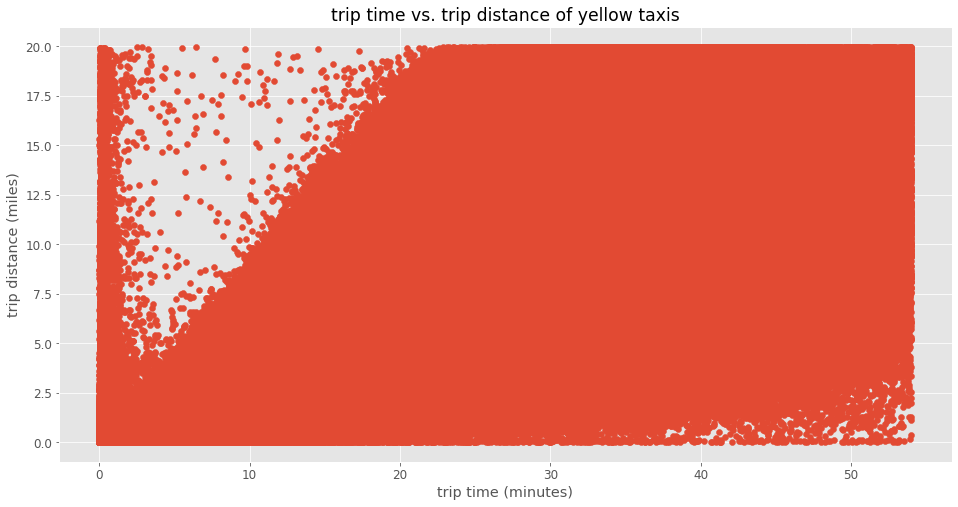

In [19]:
matplotlib.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df.trip_time, df.trip_distance)
plt.pyplot.title("trip time vs. trip distance of yellow taxis")
plt.pyplot.xlabel('trip time (minutes)')
plt.pyplot.ylabel('trip distance (miles)')
plt.pyplot.show()

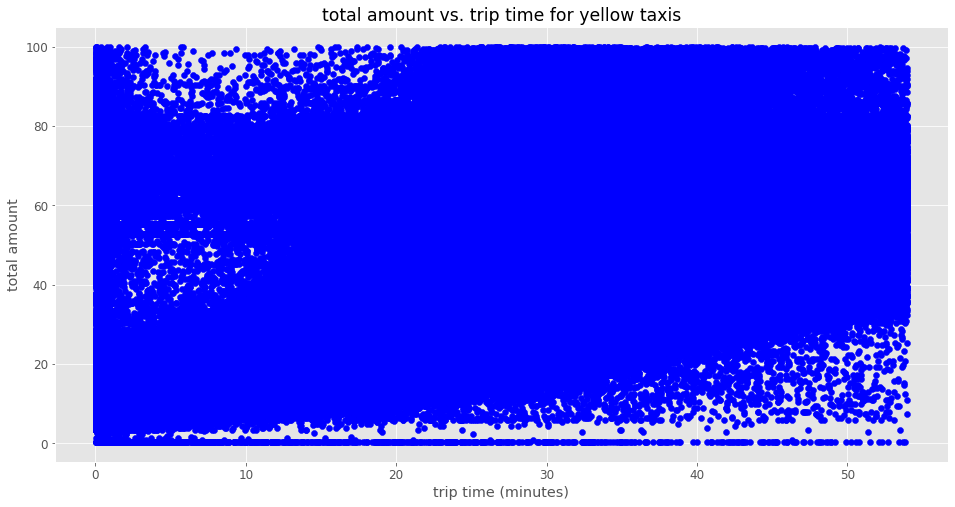

In [20]:
matplotlib.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
plt.pyplot.scatter(df.trip_time, df.total_amount, color='blue')
plt.pyplot.title("total amount vs. trip time for yellow taxis")
plt.pyplot.xlabel('trip time (minutes)')
plt.pyplot.ylabel('total amount')
plt.pyplot.show()

In [21]:
is_tipped_list = [bool(i) for i in df['tip_amount'].to_list()]
df['is_tipped'] = is_tipped_list

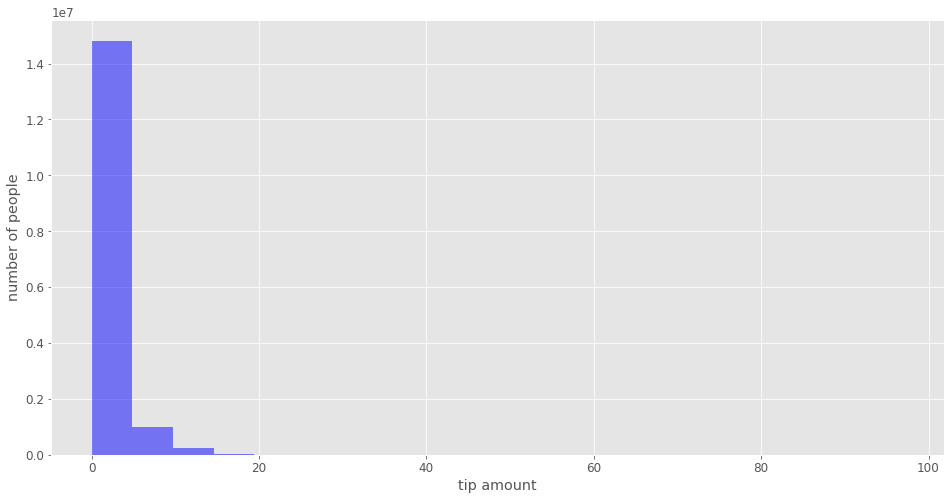

In [22]:
plt.rcParams.update({'font.size': 12})
plt.pyplot.figure(figsize=(16, 8))
n, bins, patches = plt.pyplot.hist(df.tip_amount, 20, facecolor='blue', alpha=0.5)
plt.pyplot.xlabel('tip amount')
plt.pyplot.ylabel('number of people')
plt.pyplot.show()

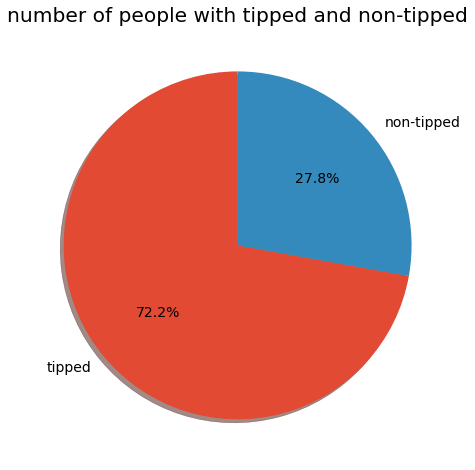

In [23]:
plt.rcParams.update({'font.size': 14})
plt.pyplot.figure(figsize=(10, 8))
is_tipped_total = df['is_tipped'].value_counts().to_list()
plt.pyplot.pie(is_tipped_total, labels=['tipped', 'non-tipped'], autopct='%1.1f%%', shadow=True, startangle=90)
plt.pyplot.title('number of people with tipped and non-tipped')
plt.pyplot.show()

In [24]:
zones = gpd.read_file('dataset/taxi_zones/taxi_zones.shp').to_crs({'init' :'epsg:4326'})
zones

D:\Anaconda\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((-74.18445 40.69500, -74.18449 40.695..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((-73.84793 40.87134, -73.84725 40.870..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((-73.97177 40.72582, -73.97179 40.725..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((-74.17422 40.56257, -74.17349 40.562..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((-73.85107 40.91037, -73.85207 40.909..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((-73.90175 40.76078, -73.90147 40.759..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((-74.01333 40.70503, -74.01327 40.704..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((-73.94383 40.78286, -73.94376 ..."


In [25]:
df_try = df
df_try.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time,is_tipped
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,N,238,239,1.0,...,0.5,1.47,0.0,0.3,11.27,2.5,00,00,4.800000,True
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.20,1.0,N,239,238,1.0,...,0.5,1.50,0.0,0.3,12.30,2.5,00,00,7.416667,True
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.60,1.0,N,238,238,1.0,...,0.5,1.00,0.0,0.3,10.80,2.5,00,00,6.183333,True
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.80,1.0,N,238,151,1.0,...,0.5,1.36,0.0,0.3,8.16,0.0,00,01,4.850000,True
5,2.0,2020-01-01 00:09:44,2020-01-01 00:10:37,1.0,0.03,1.0,N,7,193,2.0,...,0.5,0.00,0.0,0.3,3.80,0.0,00,00,0.883333,False


In [26]:
df_raw = df

In [27]:
df_pu = zones[['LocationID', 'borough']]
df_pu.columns = ['PULocationID', 'PUBorough']

df_do = zones[['LocationID', 'borough']]
df_do.columns = ['DOLocationID', 'DOBorough']

In [28]:
df_try = df_try.merge(df_pu, left_on="PULocationID", right_on="PULocationID")

In [29]:
df_try = df_try.merge(df_do, left_on="DOLocationID", right_on="DOLocationID")

In [30]:
df = df_try
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time,is_tipped,PUBorough,DOBorough
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.20,1.0,N,238,239,1.0,...,0.00,0.3,11.27,2.5,00,00,4.800000,True,Manhattan,Manhattan
1,2.0,2020-01-01 00:24:22,2020-01-01 00:25:54,1.0,0.56,1.0,N,238,239,1.0,...,0.00,0.3,9.00,2.5,00,00,1.533333,True,Manhattan,Manhattan
2,2.0,2020-01-01 00:46:46,2020-01-01 00:49:17,1.0,0.62,1.0,N,238,239,1.0,...,0.00,0.3,9.30,2.5,00,00,2.516667,True,Manhattan,Manhattan
3,1.0,2020-01-01 00:17:53,2020-01-01 00:22:47,1.0,0.80,1.0,Y,238,239,1.0,...,0.00,0.3,11.15,2.5,00,00,4.900000,True,Manhattan,Manhattan
4,2.0,2020-01-01 00:49:45,2020-01-01 00:54:12,1.0,0.86,1.0,N,238,239,1.0,...,0.00,0.3,11.16,2.5,00,00,4.450000,True,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15974534,2.0,2020-02-06 16:49:50,2020-02-06 17:38:27,1.0,2.84,1.0,N,5,99,1.0,...,0.00,0.3,31.30,0.0,16,17,48.616667,False,Staten Island,Staten Island
15974535,2.0,2020-04-30 16:24:59,2020-04-30 16:30:48,1.0,5.32,1.0,N,23,99,2.0,...,12.24,0.3,29.54,0.0,16,16,5.816667,False,Staten Island,Staten Island
15974536,2.0,2020-01-17 03:12:11,2020-01-17 03:12:29,1.0,0.21,1.0,N,99,99,2.0,...,0.00,0.3,4.30,0.0,03,03,0.300000,False,Staten Island,Staten Island
15974537,2.0,2020-02-04 18:46:39,2020-02-04 19:24:05,1.0,14.38,1.0,N,187,99,1.0,...,0.00,0.3,45.30,0.0,18,19,37.433333,False,Staten Island,Staten Island


In [31]:
def select_attribute(df, attribute='PULocationID'):
    dic = df.passenger_count.groupby(df[attribute]).count().to_dict()
    for i in range(1, 264):
        if i not in dic.keys():
            dic[i] = 0
    dic = dict(OrderedDict(sorted(dic.items())))
    se = pd.Series(dic)
    return pd.DataFrame({'{}'.format(attribute):se.index, 'passenger_count':se.values})

In [32]:
df_pick = select_attribute(df, 'PULocationID')
df_drop = select_attribute(df, 'DOLocationID')

In [33]:
df_pj = zones
df_dj = zones

In [34]:
df_pj['passenger_count'] = df_pick['passenger_count']
source = GeoJSONDataSource(geojson=df_pj.to_json())

color_mapper = LinearColorMapper(palette='Plasma256', low=0, high=df_pj['passenger_count'].max())

fig = figure(title='number of pick up passengers for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

# hover = HoverTool(
#     point_policy='follow_mouse',
#     tooltips=('<div><b>Borough</b>: @borough</div>'
#               '<div><b>Zone</b>: @zone</div>'
#               '<div><b>LocationID</b>: @LocationID</div>'
#               '<div><b>Rides</b>: @passenger_count</div>')
# )
# fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

In [35]:
df_dj['passenger_count'] = df_drop['passenger_count']
source = GeoJSONDataSource(geojson=df_dj.to_json())

color_mapper = LinearColorMapper(palette='Plasma256', low=0, high=df_dj['passenger_count'].max())

fig = figure(title='number of drop off passengers for yellow taxis')
fig.title.text_font_size = '14pt'
fig.patches(xs='xs', ys='ys', alpha=0.9, source=source, color={'field': 'passenger_count', 'transform': color_mapper}, line_width=1, line_alpha=0.5, line_color='black')

# hover = HoverTool(
#     point_policy='follow_mouse',
#     tooltips=('<div><b>Borough</b>: @borough</div>'
#               '<div><b>Zone</b>: @zone</div>'
#               '<div><b>LocationID</b>: @LocationID</div>'
#               '<div><b>Rides</b>: @passenger_count</div>')
# )
# fig.add_tools(hover)

fig.xaxis.visible = False
fig.yaxis.visible = False
fig.grid.visible = False

color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(), location=(0, 0), label_standoff=12)
fig.add_layout(color_bar, 'right')

show(fig)

## Modeling

In [36]:
from sklearn.model_selection import train_test_split, validation_curve, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize, LabelEncoder

from pylab import *

In [37]:
# Select random samples from original dataset

df_sample = df.sample(1000000)
df_sample.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time,is_tipped,PUBorough,DOBorough
6774342,1.0,2020-03-07 16:06:06,2020-03-07 16:17:47,1.0,1.50,1.0,N,90,79,1.0,...,0.0,0.3,13.57,2.5,16,16,11.683333,True,Manhattan,Manhattan
6126190,2.0,2020-03-13 17:45:30,2020-03-13 17:50:35,2.0,1.36,1.0,N,141,262,1.0,...,0.0,0.3,11.30,2.5,17,17,5.083333,True,Manhattan,Manhattan
5694030,2.0,2020-02-29 18:10:39,2020-02-29 18:20:05,1.0,0.53,1.0,N,90,249,2.0,...,0.0,0.3,10.30,2.5,18,18,9.433333,False,Manhattan,Manhattan
225875,2.0,2020-02-04 08:22:56,2020-02-04 08:26:49,3.0,0.48,1.0,N,142,239,1.0,...,0.0,0.3,9.36,2.5,08,08,3.883333,True,Manhattan,Manhattan
4839378,2.0,2020-01-25 16:13:44,2020-01-25 16:27:59,2.0,2.00,1.0,N,239,48,1.0,...,0.0,0.3,17.16,2.5,16,16,14.250000,True,Manhattan,Manhattan


In [38]:
le = LabelEncoder()
df_sample["PUBoroughID"] = le.fit_transform(df_sample["PUBorough"])
df_sample["DOBoroughID"] = le.fit_transform(df_sample["DOBorough"])
df_sample.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,total_amount,congestion_surcharge,pickup_hour,dropoff_hour,trip_time,is_tipped,PUBorough,DOBorough,PUBoroughID,DOBoroughID
6774342,1.0,2020-03-07 16:06:06,2020-03-07 16:17:47,1.0,1.50,1.0,N,90,79,1.0,...,13.57,2.5,16,16,11.683333,True,Manhattan,Manhattan,3,3
6126190,2.0,2020-03-13 17:45:30,2020-03-13 17:50:35,2.0,1.36,1.0,N,141,262,1.0,...,11.30,2.5,17,17,5.083333,True,Manhattan,Manhattan,3,3
5694030,2.0,2020-02-29 18:10:39,2020-02-29 18:20:05,1.0,0.53,1.0,N,90,249,2.0,...,10.30,2.5,18,18,9.433333,False,Manhattan,Manhattan,3,3
225875,2.0,2020-02-04 08:22:56,2020-02-04 08:26:49,3.0,0.48,1.0,N,142,239,1.0,...,9.36,2.5,08,08,3.883333,True,Manhattan,Manhattan,3,3
4839378,2.0,2020-01-25 16:13:44,2020-01-25 16:27:59,2.0,2.00,1.0,N,239,48,1.0,...,17.16,2.5,16,16,14.250000,True,Manhattan,Manhattan,3,3
1838129,2.0,2020-03-02 14:03:59,2020-03-02 14:07:56,1.0,0.81,1.0,N,249,211,1.0,...,9.30,2.5,14,14,3.950000,True,Manhattan,Manhattan,3,3
5874074,2.0,2020-03-13 15:24:16,2020-03-13 15:35:20,1.0,2.06,1.0,N,236,74,1.0,...,16.64,2.5,15,15,11.066667,True,Manhattan,Manhattan,3,3
9067975,2.0,2020-02-12 19:59:48,2020-02-12 20:09:08,1.0,1.37,1.0,N,113,144,1.0,...,12.80,2.5,19,20,9.333333,True,Manhattan,Manhattan,3,3
11325515,1.0,2020-01-15 20:36:09,2020-01-15 20:46:19,1.0,1.60,1.0,N,161,107,1.0,...,15.35,2.5,20,20,10.166667,True,Manhattan,Manhattan,3,3
1961414,2.0,2020-02-10 15:12:19,2020-02-10 15:46:01,3.0,3.73,1.0,N,236,90,1.0,...,30.47,2.5,15,15,33.700000,True,Manhattan,Manhattan,3,3


In [39]:
# df_test = df.sample(100000)
# df_test

In [40]:
# data = df_sample[['trip_distance', 'PULocationID', 'DOLocationID', 'trip_time', 'trip_distance', 
#            'passenger_count', 'improvement_surcharge', 'congestion_surcharge', 'tolls_amount']]

data = df_sample[['trip_distance', 'PUBoroughID', 'DOBoroughID', 'trip_time', 
           'passenger_count', 'improvement_surcharge', 'congestion_surcharge', 'tolls_amount']]
data.head()

,trip_distance,PUBoroughID,DOBoroughID,trip_time,passenger_count,improvement_surcharge,congestion_surcharge,tolls_amount
6774342,1.50,3,3,11.683333,1.0,0.3,2.5,0.0
6126190,1.36,3,3,5.083333,2.0,0.3,2.5,0.0
5694030,0.53,3,3,9.433333,1.0,0.3,2.5,0.0
225875,0.48,3,3,3.883333,3.0,0.3,2.5,0.0
4839378,2.00,3,3,14.250000,2.0,0.3,2.5,0.0


In [41]:
labels = df_sample['is_tipped']
labels

6774342      True
6126190      True
5694030     False
225875       True
4839378      True
            ...  
9572965     False
4066252      True
467794       True
12054731     True
1683795      True
Name: is_tipped, Length: 1000000, dtype: bool

In [42]:
X_train, X_devel, y_train, y_devel = train_test_split(data, labels, test_size=0.3, random_state=42)

In [43]:
mnb = MultinomialNB().fit(X_train, y_train)
mnb.score(X_train, y_train), mnb.score(X_devel, y_devel)

(0.72164, 0.7217466666666666)

In [44]:
# sc = StandardScaler()
# data_scaled = sc.fit_transform(data)
# data_scaled

In [45]:
# Use loss function to handle potential outliers
sgd = SGDClassifier(loss='log', random_state=42).fit(X_train, y_train)
sgd.score(X_train, y_train), sgd.score(X_devel, y_devel)

(0.7334771428571428, 0.7335766666666667)

In [46]:
lr = LogisticRegression().fit(X_train, y_train)
lr.score(X_train, y_train), lr.score(X_devel, y_devel)

(0.7324685714285715, 0.7325766666666667)

In [47]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
rf.score(X_train, y_train), rf.score(X_devel, y_devel)

(0.8844242857142857, 0.6712966666666667)

## Evaluate models

In [48]:
y_pred_lr = lr.predict(X_devel)
print(classification_report(y_devel, y_pred_lr))

              precision    recall  f1-score   support

       False       0.59      0.13      0.21     83478
        True       0.74      0.96      0.84    216522

    accuracy                           0.73    300000
   macro avg       0.66      0.55      0.53    300000
weighted avg       0.70      0.73      0.66    300000



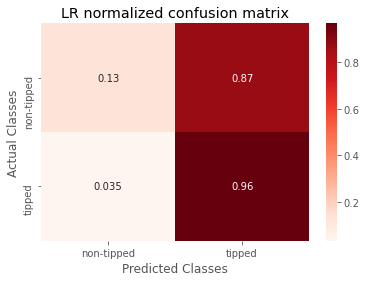

In [49]:
plt.rcParams.update({'font.size': 10})

matrix_lr = confusion_matrix(y_devel, y_pred_lr)
normed_matrix_lr = normalize(matrix_lr, axis=1, norm='l1')

sns.heatmap(normed_matrix_lr, annot=True, xticklabels=['non-tipped', 'tipped'], yticklabels=['non-tipped', 'tipped'], cmap='Reds')
plt.title('LR normalized confusion matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

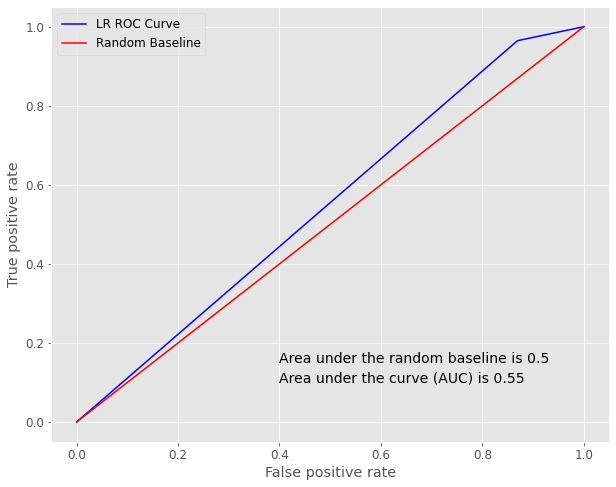

In [50]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

fpr, tpr, thr = roc_curve(y_devel, y_pred_lr)
auc = roc_auc_score(y_devel, y_pred_lr)
plt.plot(fpr, tpr, label='LR ROC Curve', color='b')
plt.plot(fpr, fpr, label='Random Baseline', color='r')
plt.text(0.4, 0.1, 'Area under the curve (AUC) is ' + str(round(auc, 2)), fontsize=14)
plt.text(0.4, 0.15, 'Area under the random baseline is 0.5', fontsize=14)
xlabel('False positive rate')
ylabel('True positive rate')
plt.legend()
plt.show()

In [51]:
y_pred_rf = rf.predict(X_devel)

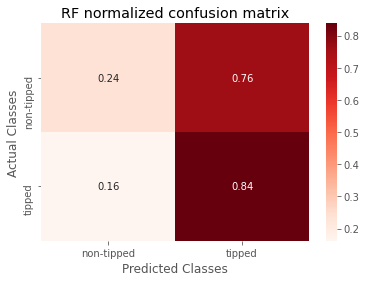

In [52]:
plt.rcParams.update({'font.size': 10})

matrix_rf = confusion_matrix(y_devel, y_pred_rf)
normed_matrix_lr = normalize(matrix_rf, axis=1, norm='l1')

sns.heatmap(normed_matrix_lr, annot=True, xticklabels=['non-tipped', 'tipped'], yticklabels=['non-tipped', 'tipped'], cmap='Reds')
plt.title('RF normalized confusion matrix')
plt.xlabel('Predicted Classes')
plt.ylabel('Actual Classes')
plt.show()

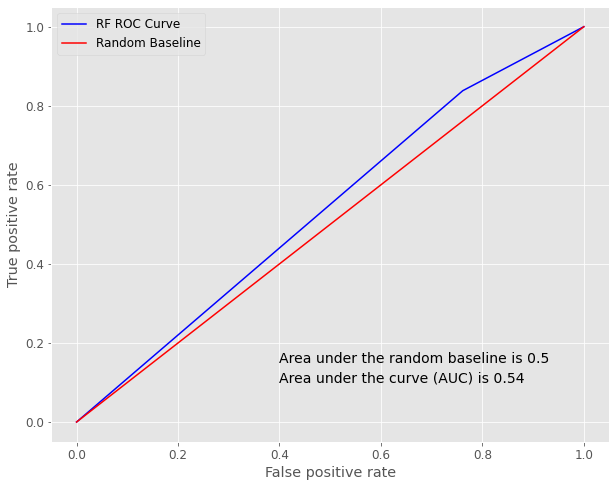

In [53]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

fpr, tpr, thr = roc_curve(y_devel, y_pred_rf)
auc = roc_auc_score(y_devel, y_pred_rf)
plt.plot(fpr, tpr, label='RF ROC Curve', color='b')
plt.plot(fpr, fpr, label='Random Baseline', color='r')
plt.text(0.4, 0.1, 'Area under the curve (AUC) is ' + str(round(auc, 2)), fontsize=14)
plt.text(0.4, 0.15, 'Area under the random baseline is 0.5', fontsize=14)
xlabel('False positive rate')
ylabel('True positive rate')
plt.legend()
plt.show()

In [54]:
fi_lr = pd.DataFrame()
fi_lr['Feature'] = data.columns
fi_lr['Importance'] = lr.coef_[0]
fi_lr = fi_lr.sort_values(by=['Importance'], ascending=False)
fi_lr

,Feature,Importance
6,congestion_surcharge,0.552262
7,tolls_amount,0.060926
3,trip_time,0.009844
5,improvement_surcharge,-0.000927
0,trip_distance,-0.004497
4,passenger_count,-0.025677
2,DOBoroughID,-0.042066
1,PUBoroughID,-0.072658


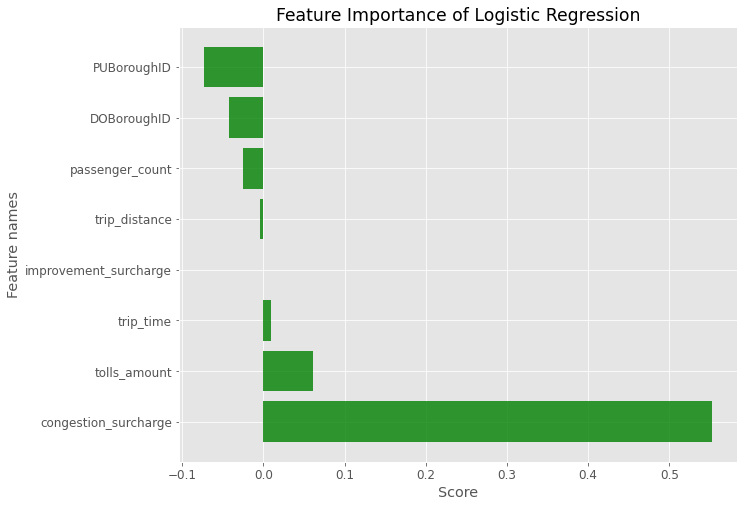

In [55]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

plt.barh(fi_lr['Feature'].to_list(), fi_lr['Importance'].to_list(), color='green', alpha=0.8)
plt.xlabel("Score")
plt.ylabel("Feature names")
plt.title("Feature Importance of Logistic Regression")
plt.show()

In [56]:
fi_rf = pd.DataFrame()
fi_rf['Feature'] = data.columns
fi_rf['Importance'] = rf.feature_importances_
fi_rf = fi_rf.sort_values(by=['Importance'], ascending=False)
fi_rf

,Feature,Importance
3,trip_time,0.628515
0,trip_distance,0.302644
6,congestion_surcharge,0.031009
2,DOBoroughID,0.015520
4,passenger_count,0.009674
1,PUBoroughID,0.007547
7,tolls_amount,0.004820
5,improvement_surcharge,0.000271


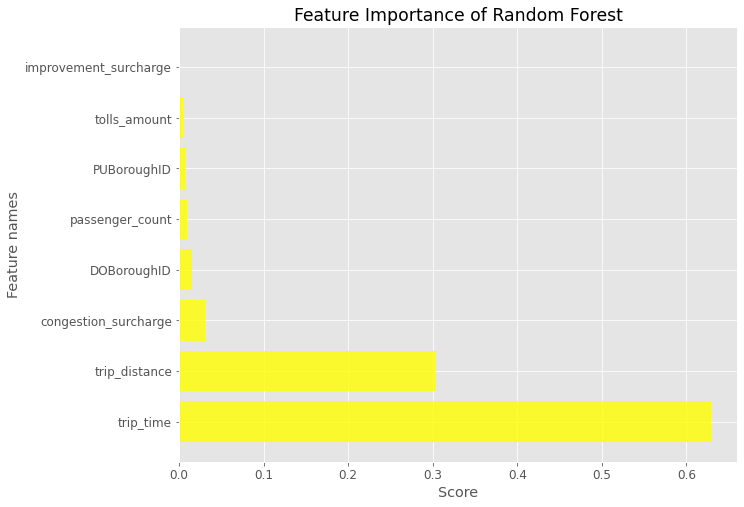

In [57]:
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 12})

plt.barh(fi_rf['Feature'].to_list(), fi_rf['Importance'].to_list(), color='yellow', alpha=0.8)
plt.xlabel("Score")
plt.ylabel("Feature names")
plt.title("Feature Importance of Random Forest")
plt.show()

In [58]:
train_size, learn_train, learn_test = learning_curve(rf, X_train, y_train, train_sizes=np.linspace(0.1,1,5))

In [59]:
mean_learn_train = np.mean(learn_train,axis=1)
std_learn_train = np.std(learn_train,axis=1)
mean_learn_test = np.mean(learn_test,axis=1)
std_learn_test = np.std(learn_test,axis=1)

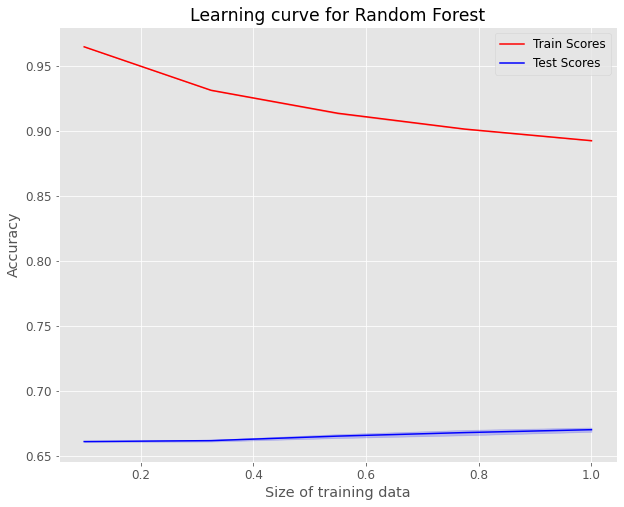

In [60]:
plt.figure(figsize=(10, 8))

plt.plot(np.linspace(0.1,1,5),mean_learn_train,label="Train Scores",color="r")
plt.fill_between(np.linspace(0.1,1,5),mean_learn_train-std_learn_train,
                mean_learn_train+std_learn_train,alpha=0.2,color="r")

plt.plot(np.linspace(0.1,1,5),mean_learn_test,label="Test Scores",color="b")
plt.fill_between(np.linspace(0.1,1,5),mean_learn_test-std_learn_test,
                mean_learn_test+std_learn_test,alpha=0.2,color="b")

plt.legend(loc="best")

plt.title("Learning curve for Random Forest")
plt.xlabel("Size of training data")
plt.ylabel("Accuracy")
plt.show()

In [63]:
df_yellow = pd.concat(df_list_yellow)

df_yellow.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'pickup_hour', 'dropoff_hour'],
      dtype='object')

In [64]:
f = pd.DataFrame()
f['features'] = df_yellow.columns
f

,features
0,VendorID
1,tpep_pickup_datetime
2,tpep_dropoff_datetime
3,passenger_count
4,trip_distance
5,RatecodeID
6,store_and_fwd_flag
7,PULocationID
8,DOLocationID
9,payment_type
